### Rebecq, H., Gallego, G., Mueggler, E., and Scaramuzza, D. (2017). EMVS: Event-Based Multi-View Stereo—3D Reconstruction with an Event Camera in Real-Time. International Journal of Computer Vision 1–21.

This notebook is an implementation of the above paper on semi-dense 3D reconstruction of a scene using back projection methods. The scene data is captured using an event camera. 

In [5]:
import cv2
import os
import scipy
import numpy as np
import matplotlib.pyplot as plt
import time
import pyquaternion as qt
%matplotlib notebook
data_path = 'data/slider_depth'

## Table of Contents
[1. Scene Video(optional)](#scene_video)

[2. Data Available and Data format](#data)
    
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1 Camera Matrix](#cam_mat)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2 Obtaining pose information relevant to events under consideration from the groundtruth files](#event_data)
 
[3. Stages of Reconstruction](#stages)

   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1 Back-Projection](#stage_1)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2 Ray-Counting](#stage_2)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3 Voting](#stage_3)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.4 Scene Restructuring](#stage_4)
   
   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.5 Cleaning](#stage_5)
   
    
[4. Algorithm](#algorithm)

   &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1 Pictorial Representation of the Algorithm](#algo_pic)

[5. The Main Function](#main)

<a id="scene_video"></a>
## 1. Scene Video


The DAVIS camera has a conventional image capturing system along with the event based system. While we shall not be using the conventional stream during our implementation, the conventional stream of data helps the user visualize the scene that is undergoing reconstruction.

In [2]:
normal_img_path = data_path + '/images'
normal_imgs = [normal_img_path + "/" + img for img in os.listdir(normal_img_path) if img.endswith(".png")]
normal_imgs.sort()

<IPython.core.display.Javascript object>


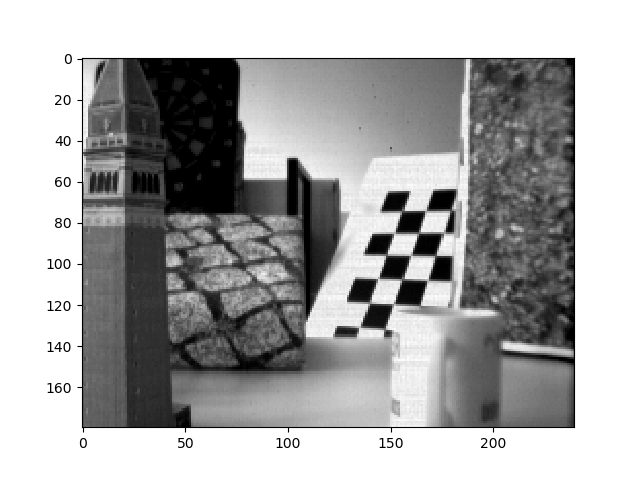

In [6]:
#### optional code snippet, Run this part if you wish to visualise the data as a video. The below sequence makes use
#### of conventional images frames and is not used anywhere else later in the notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.canvas.draw()
ax.axis()
for image in normal_imgs:
    ax.clear()
    ax.imshow(plt.imread(image), cmap='gray')
    fig.canvas.draw()

<a id="data"></a>
## 2. Data Available and Data format


There are various kinds of data which we would have to work with namely, event data, imu data, calibration parameters, and ground truth data. There is also an 'images.txt' file which gives the timestamps at which synchronous event stream was captured. The format of the data are as shown below. 

![description of dataset format](Images/data_format_emvs.png)

<a id="cam_mat"></a>
### 2.1 Camera Matrix

Every camera has a calibration matrix which is dependant on the intrinsic and extrinsic parameters being used. We obtain these parameters from the <i>calib.txt</i> file.

In [7]:
def return_camera_matrix(filename='calib.txt'):
    '''
    Returns the camera matrix for the given dataset based on calibration parameters.
    
    Parameters:
    -----------
    filename : <string>
        name of the text file where the camera parameters are stored
    
    Return:
    -------
    camera_mat: <np.array>
        The camera matrix for the parameters mentioned in the calibration file
    '''
    
    file = open(data_path +'/' + filename, "r")
    cam_par = list(map(float,file.readline().split()))
    file.close()
    fx, fy, cx, cy, k1, k2, p1, p2, k3 = [par for par in cam_par]
    camera_mat = np.array([[fx,  0, cx],
                           [ 0, fy, cy],
                           [ 0,  0,  1]])
    return camera_mat, [k1, k2, p1, p2, k3]

In [8]:
def return_undistorted_coordinates(dist_cam_cords, distortion_params):
    '''
    Utility under consideration
    '''
    k1, k2, p1, p2, k3 = distortion_params
    
    pass

In [9]:
cam_mat, dist_params = return_camera_matrix()

<a id="event_data"></a>
### 2.2 Obtaining pose information relevant to events under consideration from the groundtruth files


The objective is to get an event and its corresponding pose for that particular time stamp. Since the number of events are huge and the homographies are expensive to compute, a batch of 256 events is assigned the same pose information. 

In [10]:
from itertools import islice
def bundle_events(batch_number, filename='events.txt', batch_size = 256):
    ''' 
    Return a batch of events from the file containing event information. Sometimes the event file can run into several 
    Gigabytes of storage. This is why a file is opened and closed everytime a batch of events needs to be read.
    
    Parameters:
    -----------
    batch_number : <int>
        The nth batch which needs to be read
    filename : <string>
    '''
    events=[]
    file = open(data_path +'/' + filename, "r")
    head = list(islice(file, batch_number * batch_size, (batch_number + 1)*batch_size))
    #return timestamp of first event in the batch
    event_start_time = list(map(float,head[0].split()))[0] 
    for line in head:
        events.append(list(map(float,line.split())))
    file.close()
    return events, event_start_time

In [182]:
events, event_start_time = bundle_events(batch_number=40)
print(event_start_time)

0.048514001


The pose is sampled at frequencies lower than the event data. In order to capture pose information for an event at some timestamp, it is thus necessary to linearly interpolate the pose data for that timestamp. As the trajectory is continuous and the sampling time is very small, we can assume the path between two timesteps to be fairly linear.

In [12]:
def get_ground_truth_pose(event_start_time, filename='groundtruth.txt'):
    
    ''' 
    This function returns the the groundtruth pose for an event depending on the timestamp 
    of the input given as input to the function. If pose of the event is linearly interpolated 
    if the timestamp of the event given falls in between the timestamps of the poses of the two 
    events
    
    Parameters:
    -----------
    event_start_time : <float>
        timestamp of event for which pose information is to be estimated
    filename : <string>
        name of the file containing the groundtruth
        
    Return:
    -------
    pose : <list> of format [timestamp, px, py, pz, qx, qy, qz, qw]
        Returns a list describing the pose at the timestamp given by the event
    
    '''
    file = open(data_path +'/' + filename, "r")
    prev_pose = [0, 0, 0, 0, 0, 0, 0, 1]
    prev_time = prev_pose[0]  #start with initial time 0s 
    
    for line in file:
        current_pose = list(map(float,line.split()))
        current_time = current_pose[0]
        
        if event_start_time == current_time:
            return np.array(current_pose) #pose information for that time-step
        
        elif event_start_time > prev_time and event_start_time < current_time:
            return linearly_interpolated_pose(current_pose, prev_pose, event_start_time) 
            
        elif event_start_time > current_time:
            prev_pose = current_pose
            prev_time = prev_pose[0]

In [13]:
def linearly_interpolated_pose(pose_t, pose_t_minus_1, time_bet):
    
    ''' 
    Function to linearly interpolate the quaternion and translation values for the timesteps provided
    
    Parameters:
    -----------
    pose_t : <list>
        list containing pose information of the time step greater than required time 
    pose_t_minus_1 : <list>
        list containing pose information of the time step lesser than required time
    time_bet: <float>
        Time for which pose information is required
    
    Return:
    -------
    estimated_pose : <list>
        Returns a list containing the linearly interpolated pose estimate
    '''
    
    # We will doing slerp on quaternions and linear intepolation on the translation vectors
    estimated_pose = []
    interpolater = time_bet/(pose_t[0] - pose_t_minus_1[0])
    
    interpolated_translation = interpolater *(np.array(pose_t[1:4]) - np.array(pose_t_minus_1[1:4]))
    
    
    pose_t_minus_1_qt = qt.Quaternion(pose_t_minus_1[7], pose_t_minus_1[4], pose_t_minus_1[5], pose_t_minus_1[6])
    
    pose_t_qt = qt.Quaternion(pose_t[7], pose_t[4], pose_t[5], pose_t[6]) 
    # the order of pose in the dataset and that used in the pyquaternion library is different, hence the restructuring
    
    interpolated_rotation = qt.Quaternion.slerp(pose_t_minus_1_qt, pose_t_qt, interpolater)
    eqw ,eqx, eqy, eqz = interpolated_rotation.elements
    px, py, pz = interpolated_translation
    
    return [time_bet, px, py, pz, eqx, eqy, eqz, eqw]

The below code is run to see how the pose information is calculated for different event times where the events are sampled in batches.

In [178]:
def get_info():
    for batch in range(10):
        events, event_start_time = bundle_events(batch)
        info = get_ground_truth_pose(event_start_time)
        #print('For batch number {}, the event starts at {} second with translation vector, t={} and rotational quaternion={}'
              #.format(batch, info[0], info[1:4], info[4:]))

In [175]:
get_info()

For batch number 0, the event starts at 0.003811 second with translation vector, t=[0.019094251027136612, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 1, the event starts at 0.005727 second with translation vector, t=[0.02869398468444276, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 2, the event starts at 0.007580001 second with translation vector, t=[0.03797807448962123, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 3, the event starts at 0.009142 second with translation vector, t=[0.04580415714775201, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 4, the event starts at 0.010625001 second with translation vector, t=[0.05323443617359683, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 5, the event starts at 0.012172001 second with translation vector, t=[0.06098536935097293, 0.0, 0.0] and rotational quaternion=[0.0, 0.0, 0.0, 1.0]
For batch number 6

In [179]:
%timeit get_info()

12.2 ms ± 32.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [148]:
def get_translation_rotation(pose):
    
    '''
    Get the translation vector and rotation matrix from the pose which contains a quaternion
    
    Parameters:
    -----------
    pose : <list>
        A list contating the translation vectors and quaternion for rotation
    
    Return:
    -------
    t : <np.array, 1x3>
        An array of translation co-ordinates
    R : <np.array, 3x3>
        A matrix containing the rotational information
    '''
    
    pose_qt = qt.Quaternion(pose[7], pose[4], pose[5], pose[6])
    R = pose_qt.rotation_matrix
    t = np.array(pose[1:4])
    t = t.reshape((3,1))
    return t,R

In [149]:
t, R = get_translation_rotation([0.003811, 0.019094251027136612, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])
print("Translation:\n{} \n Rotation:\n{}".format(t, R))

Translation:
[[0.01909425]
 [0.        ]
 [0.        ]] 
 Rotation:
[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]


In [150]:
%timeit get_translation_rotation([0.003811, 0.019094251027136612, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0])

45.2 µs ± 545 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [228]:
t = np.array([0.019094251027136612, 0, 0]).reshape(3, 1)
R = np.random.rand(3,3)

<a id="stages"></a>
## 3. Stages of Reconstruction


The algorithm for Event based Multi View Stereo proposed here uses five stages to do the reconstruction. It makes use of the Collins space sweep approach with a few changes. Projective sampling is used instead of uniform sampling. Also the thresholding is Adaptive Gaussian as opposed to Global thresholding used in Collins' algorithm.

<a id="stage_1"></a>
### 3.1 Backprojection


The 2-D points in the event stream are backprojected into a 3-D space. Since the event camera detects only edges, we can assume the rays corresponding to the same feature would intersect/ go very close to each in some unit volume.

<img src="Images/backprojection.png" alt="backprojection" style="width: 400px;"/>


In [232]:
def map_to_reference_view(events, t, R):
    '''
    Function to find out the initial homography matrix to map event co-ordinates to the Z_0 plane of 
    the reference view
    
    Parameters:
    -----------
    event : <np.array, batch_sizex4>
        A  containing event information namely [timestamp, ex, ey, polarity] of one batch of size batch_size
    t : <np.array, 3x1>
        The translation part of the pose
    R : <np.array, 3x3>
        The Rotational part of the pose
        
    Return:
    -------
    mapped_coordinates : <np.array, batch_sizex2>
        all the x and y co-ordinates mapped to the reference Z_0
    
    '''
    co_ords = np.vstack((events[:, 1], events[:, 2], np.ones((events.shape[0], )))) 

    e = np.reshape(np.array([0, 0, 1]), (1, 3)) 
    H_Z0  = np.linalg.inv(R + (t @ e)/Z_0)
    mapped_coordinates = (H_Z0 @ co_ords).T      
    
    return mapped_coordinates[:,0:2]

In [233]:
n = np.array(events)

In [270]:
ref_plane_mapped_events = map_to_reference_view(n, t, R)


In [271]:
%timeit map_to_reference_view(n, t, R)

92.8 µs ± 605 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [281]:
def homography(ref_plane_mapped_events, Z_i, t, R):
    '''
    Compute the homography for the input positions and  pose. The homography has been calculated as per
    the methods outlined in the paper in section 7.1. Z_0 is defined as a global variable later in the code
    
    Parameters:
    -----------
    ref_plane_mapped_events : <np.array, batch_sizex2>
        Event coordinates mapped to the reference plane
        
    Z_i : <int> 
        Current depth plane
    t : <np.array, 1x3>
        An array of translation co-ordinates
    R : <np.array, 3x3>
        A matrix containing the rotational information
    Return:
    -------
    depth_plane_mapped_events : <np.array, batch_sizex2>
        Event coordinates mapped to the current depth plane
    '''
    
    Cx, Cy, Cz = -(R.T @ t).T[0]  # camera centers , fix this monstrosity
    
    delta = (Z_i - Z_0)/(Z_0 - Cz)
    
    m1 = np.vstack((ref_plane_mapped_events[:, 0], np.ones((ref_plane_mapped_events.shape[0]), dtype='float64')*Cx)).T
    m2 = np.vstack((ref_plane_mapped_events[:, 1], np.ones((ref_plane_mapped_events.shape[0]), dtype='float64')*Cy)).T
    
    m_final = np.vstack((m1,m2))
    
    m3 = np.array([[Z_0*delta/Z_i],
                  [(1-delta)/Z_i]])
    
    cur_depth_mapped_events = m_final @ m3
    
    x_ref_mapped = cur_depth_mapped_events[:ref_plane_mapped_events.shape[0]]
    y_ref_mapped = cur_depth_mapped_events[ref_plane_mapped_events.shape[0]:]
    
    depth_plane_mapped_events = np.hstack((x_ref_mapped, y_ref_mapped))
    
    return depth_plane_mapped_events

In [283]:
depth_plane_mapped_events = homography(ref_plane_mapped_events, 2, t, R)

In [284]:
%timeit homography(ref_plane_mapped_events, 2, t, R)

124 µs ± 2.57 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


<a id="stage_2"></a>
### 3.2 Volumetric Ray Counting


We assume our backprojected rays from different views to pass through some 3-D Volume divided into voxels. A scoring function is associated with each voxel. The score of each voxel is determined by the number of rays passing through it. It is given as shown below. <b>X</b> is the co-ordinate of the centre of a voxel.

<img src="Images/scoring.png" alt="scoring" style="width: 200px;"/>

In [285]:
def vote(depth_plane_mapped_events, vote_type='nearest_neighbour'):
    ''' 
    The function recieves floating values as co-ordinates. This function assigns a vote to the appropriate voxel by 
    approximating it the nearest integer co-ordinates using some correction scheme.
    
    Parameters:
    -----------
    depth_plane_mapped_events : <np.array, batch_sizex2>
        Event coordinates mapped to the current depth plane
    
    vote_type : <string>
        bilinear or nearest neighbour
        
    Return:
    -------
    x_i, y_i : <int>
        Integer values of x and y for which voting is possible
    '''
    if vote_type=='nearest_neighbour':
        depth_vol_coords = np.round(depth_plane_mapped_events).astype(int)
        return depth_vol_coords

In [292]:
vol_coords = vote(depth_plane_mapped_events)

In [287]:
% timeit vote(depth_plane_mapped_events)

11.4 µs ± 204 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [289]:
 voxel_space = np.zeros((100, 240, 180))

In [293]:
 voxel_space[2 - (Z_0+1) , vol_coords[:, 0], vol_coords[:,1]]+=1

IndexError: index -771 is out of bounds for axis 1 with size 240

<a id="stage_3"></a>
### 3.3 Thresholding


Local maxima of <b>f(X)</b> is determined here. It is done by by using adaptive gaussian thresholding on the confidence map c(x,y). After this procedure a scene structure should have been formed.

In [160]:
def gauss2D(shape=(3,3),sigma=0.5):
    ''' 
    Function supplies a 2D gaussian mask of the required shape and sigma
    
    Parameters:
    -----------
    shape : <(int, int) tuple>
        Floating point co-ordinates obtained from the homography
    
    sigma : <float>
        standard deviation of the gaussians
        
    Return:
    -------
    h : <2-D numpy array>
        returns a gaussian mask
    '''
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[h < np.finfo(h.dtype).eps*h.max()] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

In [161]:
import scipy.signal
def adaptive_gaussian_thresholding(volume_slice, kernal_shape, C):
    '''
    This function does adaptive gaussian thresholding of the 3-D voxel space
    
    Parameters
    ----------
    volume_slice : <np.array, 1 x camera_width x camera_height>
        The (1 x camera_width x camera_height) array which define the center of the voxel co-ordinates after having accumulated votes in the 
        voting process
    
    Returns
    ------- 
    thresholded_volume : <np.array, 1 x camera_width x camera_height>
        A (1 x camera_width x camera_height) array on which adaptive gaussian thresholding has been successfully performed
    '''
    threshold_mask = scipy.signal.convolve2d(volume_slice, gauss2D(kernal_shape, 1), mode='same') - C
    thresholded_slice = (volume_slice > threshold_mask).astype(np.int)
    final_values = np.multiply(volume_slice, thresholded_slice)
    return final_values

In [119]:
a = np.ones((5, 240, 180))*np.random.randint(0, 100)

In [120]:

%timeit adaptive_gaussian_thresholding(a[1,:,:], (5,5), -10)

6.3 ms ± 30.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


<a id="stage_4"></a>
### 3.4 Scene Merging


This is used to merge scenes obtained while the camera is moving. The key reference view is changed when the distance moved by the camera w.r.t to the reference view exceeds some percentage of the mean scene depth (15 to 40%)

In [164]:
def calc_mean_depth(volume):
    '''
    Calculate the mean depth of the volume. Only voxels which contain a value are considered for the mean depth
    calculation
    '''
    depth_weight = 0
    tot = 0
    for z in range(volume.shape[0]):
        vol_slice = volume[z, :, :]
        weight = len(vol_slice[vol_slice>0])
        tot += weight
        depth_weight += weight * z
    
    if tot==0:
        return 0
    else:
        mean_depth = depth_weight/tot
        return mean_depth

In [162]:
def check_reference_switch(volume, t, t_prev, mean_depth_factor = 0.2):
    '''
    return True if mean depth is 15% to 40% of the mean_depth of the scene. 
    '''
    mean_depth = calc_mean_depth(volume)
    dist_travelled = np.linalg.norm(t-t_prev)
    
    if dist_travelled > mean_depth_factor * mean_depth:
        return True
    else:
        return False

In [165]:
tplus1 = np.array([1, 0, 0]).reshape(3,1)
check_reference_switch(a ,tplus1, t)

True

In [166]:
%timeit check_reference_switch(a ,tplus1, t)

642 µs ± 17.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [171]:
def get_transformed_vol_from_prev_voxel_space(prev_vol_vectors, curr_volume, R, t):
    '''
    This generates a new 3-D space based on the 3-D space obtained after current transformation and the 
    3-D space obtained earlier(prev volume vectors). The volume vectors define the point in space where the 3-D 
    space has some value greater than 0.
    
    Parameters
    ----------
    prev_vol_vectors : <list, nx3>
        The list of vectors in the previous volume where the points defined by them had values greater than 0
    
    curr_volume : <np.array, number_of_depth_planes x camera_width x camera_height>
        The 3-D space of the current reference view
    
    Returns
    ------- 
    thresholded_volume : <np.array, 1 x camera_width x camera_height>
        A (1 x camera_width x camera_height) array on which adaptive gaussian thresholding has been successfully performed
    '''
    
    transformed_vol_vectors = []
    orig_vol_vectors = np.argwhere(curr_volume)
    
    # array is of form nX(z,x,y), the below code makes the array of form nX(x, y, z)
    ###############################################
    temp = np.copy(orig_vol_vectors[:, 0])
    orig_vol_vectors[:, 0] = orig_vol_vectors[:, 1]
    orig_vol_vectors[:, 1] = temp
    temp = np.copy(orig_vol_vectors[:, 1])
    orig_vol_vectors[:, 1] = orig_vol_vectors[:, 2]
    orig_vol_vectors[:, 2] = temp
    ################################################
    
    # Keep in mind that the shape of the vectors we get from the volume is (z,x,y) while the shape need for 
    # computing transformations is (x, y, z)
    transformed_vol_vectors = (R@(orig_vol_vectors).T + t).T
    
    #nearest neighbour voting 
    transformed_vol_vectors[:, 0] = (np.round(transformed_vol_vectors[:, 0])).astype(int)
    transformed_vol_vectors[:, 1] = (np.round(transformed_vol_vectors[:, 1])).astype(int)
    transformed_vol_vectors[:, 2] = (np.round(transformed_vol_vectors[:, 2])).astype(int)
    
    # array is of form nX(x,y,z), the below code makes the array of form nX(z, x, y)
    ###############################################
    temp = np.copy(transformed_vol_vectors[:, 0])
    transformed_vol_vectors[:, 0] = transformed_vol_vectors[:, 1]
    transformed_vol_vectors[:, 1] = temp
    temp = np.copy(transformed_vol_vectors[:, 0])
    transformed_vol_vectors[:, 0] = transformed_vol_vectors[:, 2]
    transformed_vol_vectors[:, 2] = temp
    ################################################
    
    tot_vectors = transformed_vol_vectors.tolist() + prev_vol_vectors
    volume_vectors_set = set(tuple(vector) for vector in  tot_vectors)
    volume_vectors_list = [list(vector) for vector in volume_vectors_set]

    return volume_vectors_list

In [172]:
prev_vol_vectors = [[0, 0, 1], [0, 2 ,3], [2, 4, 56], [34, 23 ,45], [21, 34 ,67]]
%timeit get_transformed_vol_from_prev_voxel_space(prev_vol_vectors, a, R, t)

250 ms ± 865 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


<a id="stage_5"></a>
### 3.5 Cleaning and Plotting


The edges obtained are cleaned using median filters and radius filters

In [50]:
def clean(volume):
    volume = median_filter(volume)
    volume = radius_filter(volume)
    return volume

In [51]:
def radius_filter(volume):
    return volume

In [52]:
def median_filter(volume):
    return volume

In [53]:
def plot_3D_space_and_convert_to_point_cloud(volume_3D, destination):
    pass

In [54]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
import time
import pylab as pl
from IPython import display

def plot_3D_space(volume_vector_list):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    xs = np.array(volume_vector_list)[:, 1]
    ys = np.array(volume_vector_list)[:, 2]
    zs = np.array(volume_vector_list)[:, 0]
    ax.scatter(xs, ys, zs)
    #display.clear_output(wait=True)
    #display.display(pl.gcf())
    #time.sleep(0.001)

<a id="algorithm"></a>
## 4. The Algorithm


The algorithm given by Rebecq et al. is as shown below. Note that there are some guidelines given by Rebecq et al. to speed up computations which must be followed.

<img src="Images/algorithm.png" alt="The Algorithm" style="width: 400px;" align='left'/>

<a id="algo_pic"></a>
### 4.1 Pictorial Representation of the Algorithm



<img src="Images/Visualization_of_ EVMS_process.png" alt="visualising EVMS homographies" style="width: 400px;" align='center'/>

<a id="main"></a>
# 5. The Main function


In [55]:
num_of_depth_planes = 100 # number of depth planes to be used for the 3-D projective Space
Z_0 = 10  # The reference plane for initial mapping, 10 has been chosen arbitrarily

In [62]:
def main():
    
    voxel_space = np.zeros((num_of_depth_planes, 240, 180)) # the resolution of the camera is 240x180
    reference_vol_vectors = []
    
    t = np.array([0, 0, 0]).reshape((3,1))
    R = np.eye(3)
    i = 0
    for batch in range(1): # Number chosen arbitrarily, should think more about this 70000
        events, event_start_time = bundle_events(batch_number=batch)
        pose = get_ground_truth_pose(event_start_time)
        t_prev, R_prev = t , R
        t, R = get_translation_rotation(pose)
        
        if check_reference_switch(voxel_space, t, t_prev):
            #voxel_space = clean(voxel_space)
            reference_vol_vectors = get_transformed_vol_from_prev_voxel_space(reference_vol_vectors, 
                                                                              voxel_space, R_prev, t_prev)   # plotting happens here
            voxel_space = np.zeros((num_of_depth_planes, 240, 180)) #  Re-initialize voxel space for new reference
               
        ref_plane_mapped_events = map_to_reference_view(np.array(events), t, R)
            
        for Z_i in range(Z_0+1, num_of_depth_planes+Z_0+1):
            #parallelize this using multithreading in the end, 
            depth_plane_mapped_events = homography(ref_plane_mapped_events, Z_i, t, R) 
            vol_coords = vote(depth_plane_mapped_events) # nearest neighbour or bilinear voting
#########################################################################################################################
##### This part of code is obsolete needs to be modified to new scheme

            voxel_space[Z_i - (Z_0+1) , vol_coords[:, 0], vol_coords[:,1]]+=1  # This line of code needs to be changed , acc to part of code before thisRay Counting    
        
        for Z_i in range(Z_0+1, num_of_depth_planes+Z_0+1):
            voxel_space[Z_i - (Z_0+1), :, :] = adaptive_gaussian_thresholding(voxel_space[Z_i - (Z_0+1), :, :], (5,5), -10) 
        i+=1
        
##########################################################################################################################       
#scored_space = clean(voxel_space)
#plt.plot(scored_space)  # plot scored space continuously
        

## Scratchpad

# recheck calculations
### Figure out how to do scene restructing and scene merging efficiently in above code
### Figure out how to vectorize the computations in adaptive gaussian thresholding and vector computation for scene restructuring

#### To-do:
##### 1. How would one use camera matrix in this paper, is it not necessary?
##### 2. Filter implementations to be done 
#### how to implement union of the transformed volume at each step?
# Parallelize the code for the depth planes part

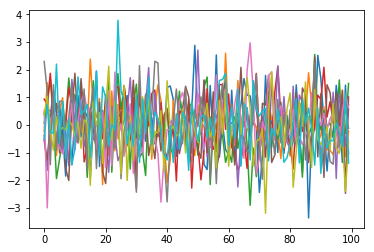

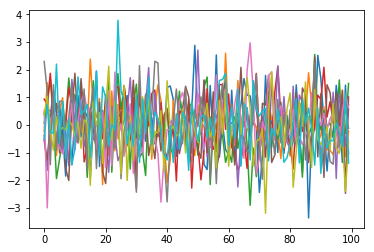

In [36]:
%matplotlib inline
import time
import pylab as pl
from IPython import display
for i in range(10):
    pl.plot(pl.randn(100))
    display.clear_output(wait=True)
    display.display(pl.gcf())
    time.sleep(1.0)
